# Quantum Harmonic Oscillator

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.circuit import Parameter, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFTGate
import numpy as np
import matplotlib.pyplot as plt

JLP encoding:

Discretize
\begin{equation}
x_{\ell} = - x_{\text{max}} + \ell \delta_x\,, \quad \delta_x = \frac{2 x_{\text{max}}}{2^{n_q} - 1}\,, \quad \ell \in [0, 2^{n_q} - 1]
\end{equation}
Eigenstates of $\hat{x}$ are now represented by the ket representing the bitstring $(\ell)_2$. For example,
\begin{equation}
\hat{x} \ket{\ell} = ( - x_{\text{max}} + \ell \delta_x ) \ket{\ell}
\end{equation}
It can be shown that this can be implemented on the Hilbert space of qubits with the following operator
\begin{equation}
\hat{x} =  -\frac{x_{\text{max}}}{2^{n_q} - 1} \sum_{\ell = 0}^{n_q - 1}2^{\ell}Z_{\ell}
\end{equation}
The conjugate momenta take the values
\begin{equation}
k_{x} = - \frac{\pi}{\delta_x} + \left(\ell + \frac{1}{2}\right) \frac{2 \pi}{2^{n_q} \delta_x}
\end{equation}
The conjugate momentum operator can be implemented as (after doing a Fourier transform)
\begin{equation}
\hat{p} = -\frac{\pi}{2^{n_q}\delta_x}\sum_{\ell = 0}^{n_q - 1} 2^{\ell} Z_{\ell}
\end{equation}


In [3]:
def rz2(qc, theta, j, k):
    qc.cx(j, k)
    qc.rz(theta, k)
    qc.cx(j, k)
    # qc.barrier()

Fourier transform is 
\begin{equation}
\ket{j} \rightarrow \frac{1}{\sqrt{2^N}}\sum_{k = 0}^{2^N - 1} e^{ 2\pi i j k / 2^N} \ket{k}
\end{equation}
But we actually want this
\begin{equation}
\ket{j} \rightarrow \frac{1}{\sqrt{2^N}}\sum_{k = 0}^{2^N - 1} e^{ 2\pi i x_j p_k / 2^N} \ket{k}
\end{equation}
But
\begin{equation}
x_j p_k = ( - x_{\text{max}} + j \delta_x) \times \left(-\frac{\pi}{\delta_x} + \left(k + \frac{1}{2} \right) \frac{2\pi}{2^{n_q} \delta_x}\right)
\end{equation}
This has the `extra terms'
\begin{equation}
x_j p_k = \frac{2\pi j k}{2^{n_q}} + 
\end{equation}

In [4]:
def trotter_step(qc: QuantumCircuit, delta_t: float, x_max: float):
    qubits = qc.num_qubits
    x_prefactor = (x_max / (2 ** qubits - 1)) ** 2
    delta_x = 2 * x_max / (2 ** qubits - 1)
    p_prefactor = (np.pi / (2 ** qubits * delta_x)) ** 2
    # first apply the x^2 evolution
    for i in range(qubits):
        for j in range(i + 1, qubits):
            rz2(qc, 2 * 2 ** (i + j) * x_prefactor * delta_t, i, j)
    # then do a fourier transform
    # do_qft(qc)
    alpha = (1 / 2 ** qubits - 1) * np.pi
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    qc.append(QFTGate(qubits), range(qubits)) # This is the QFT
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    # then again apply the p^2 evolution now
    for i in range(qubits):
        for j in range(i + 1, qubits):
            rz2(qc, 2 * 2 ** (i + j) * p_prefactor * delta_t, i, j)
    # apply the inverse fourier transform
    # do_iqft
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)
    qc.append(QFTGate(qubits).inverse(), range(qubits))
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)

Strang:

\begin{equation}
e^{A + B} = e^{A/2} e^{B} e^{A/2}
\end{equation}

In [7]:
def trotter_step_strang(qc: QuantumCircuit, delta_t: float, x_max: float):
    qubits = qc.num_qubits
    x_prefactor = (x_max / (2 ** qubits - 1)) ** 2
    delta_x = 2 * x_max / (2 ** qubits - 1)
    p_prefactor = (np.pi / (2 ** qubits * delta_x)) ** 2
    # first apply the x^2 evolution
    for i in range(qubits):
        for j in range(i + 1, qubits):
            rz2(qc, 2 * 2 ** (i + j) * x_prefactor * delta_t / 2, i, j)
    # then do a fourier transform
    # do_qft(qc)
    alpha = (1 / 2 ** qubits - 1) * np.pi
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    qc.append(QFTGate(qubits), range(qubits))
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    # then again apply the p^2 evolution now
    for i in range(qubits):
        for j in range(i + 1, qubits):
            rz2(qc, 2 * 2 ** (i + j) * p_prefactor * delta_t, i, j)
    # apply the inverse fourier transform
    # do_iqft
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)
    qc.append(QFTGate(qubits).inverse(), range(qubits))
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)
    # apply an x^2 evolution again
    for i in range(qubits):
        for j in range(i + 1, qubits):
            rz2(qc, 2 * 2 ** (i + j) * x_prefactor * delta_t / 2, i, j)

In [8]:
def full_evolution(qc: QuantumCircuit, x_max: float, num_qubits: int,
                   delta_t: float, trotter_steps: int, strang: bool = True):
    # qc = QuantumCircuit(num_qubits)
    if strang:
        for _ in range(trotter_steps):
            trotter_step_strang(qc, delta_t, x_max)
    else:
        for _ in range(trotter_steps):
            trotter_step(qc, delta_t, x_max)

Let us simulate the ground state of the harmonic oscillator now. (Should ideally use VQE here to find the ground state but since this is an exact problem we can find the ground state).

In [9]:
x_max = 10
num_qubits = 10
delta_x = 2 * x_max / (2 ** num_qubits - 1)

In [10]:
x_list = np.array([-x_max + l * delta_x for l in range(2 ** num_qubits)])
# we can check that this normalizes to one
coeffs_list = np.exp(-x_list ** 2 / 2) * np.sqrt(delta_x) / np.pi ** (1/4)

Now we can start simulating. Let's compute the expectation value of the position operator. This should be fixed in time.

In [11]:
x_op_list = [('I' * (num_qubits - i - 1) + 'Z' + 'I' * i, - 2 ** i * x_max / (2 ** num_qubits - 1)) for i in range(num_qubits)]

In [12]:
x_op = SparsePauliOp.from_list(x_op_list)

In [56]:
x_sq_op = x_op @ x_op

In [57]:
delta_t = 0.01

In [58]:
trotter_steps = 100

In [59]:
PUBs_list = []

In [60]:
for steps in range(trotter_steps):
    sho_gs = QuantumCircuit(num_qubits)
    sho_gs.initialize(coeffs_list, range(num_qubits)) # prepare the quantum circuits
    full_evolution(sho_gs, x_max, num_qubits, delta_t, steps)
    PUBs_list.append((sho_gs, [x_op, x_sq_op], []))

In [61]:
estimator = StatevectorEstimator()
job = estimator.run(PUBs_list)

In [62]:
results = job.result()

In [64]:
results[1].data.evs

array([-6.40793081e-16,  5.00000001e-01])

In [65]:
x_vals = [results[i].data.evs[0] for i in range(100)]
x_sq_vals = [results[i].data.evs[1] for i in range(100)]

In [66]:
t_values = [t * delta_t for t in range(trotter_steps)]

In [67]:
plt.rcParams['text.usetex'] = True

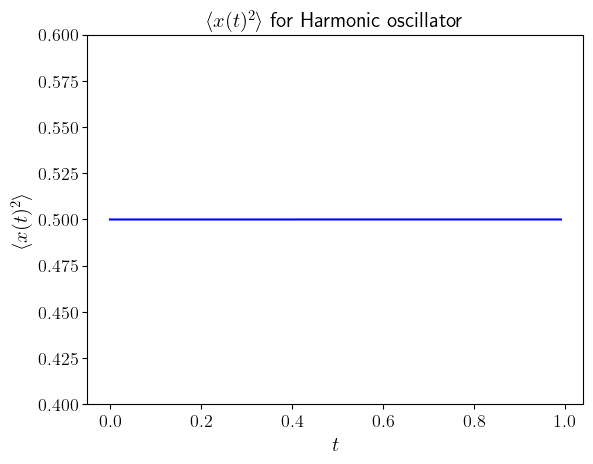

In [76]:
plt.plot(t_values, x_sq_vals, color='blue')
plt.xlabel('$t$', size = 15)
plt.ylabel(r'$\langle x(t)^2 \rangle$', size = 15)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title(r'$\langle x(t)^2 \rangle$ for Harmonic oscillator', size = 15)
plt.ylim([0.4, 0.6])
plt.savefig('./sho_x_sq_exp.png', dpi=300)
plt.show()

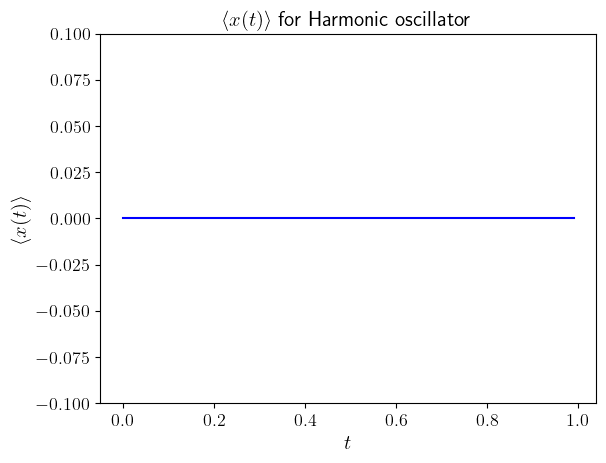

In [77]:
plt.plot(t_values, x_vals, color='blue')
plt.xlabel('$t$', size = 15)
plt.ylabel(r'$\langle x(t) \rangle$', size = 15)
plt.xticks(size=13)
plt.yticks(size=13)
plt.ylim([-0.1, 0.1])
plt.title(r'$\langle x(t) \rangle$ for Harmonic oscillator', size = 15)
plt.savefig('./sho_x_exp.png', dpi=300)
plt.show()

Let us now compute $\braket{0|\hat{x}(t)^2|0}$

For this we need to evaluate the square of the Pauli-string
\begin{equation}
x = - \frac{x_{\text{max}}}{2^{n_q} - 1} \sum_{\ell = 0}^{2^{n_q} - 1} 2^{\ell} Z_{\ell}
\end{equation}
This is easily done using the SparsePauliOp module of qiskit.quantum_info

In [16]:
x_sq_op = (x_op @ x_op).simplify()

In [17]:
x_values = []
t_values = [t * delta_t for t in range(trotter_steps)]

In [18]:
for steps in range(trotter_steps):
    sho_gs = QuantumCircuit(num_qubits)
    sho_gs.initialize(coeffs_list, range(num_qubits)) # prepare the quantum circuita
    full_evolution(sho_gs, x_max, num_qubits, delta_t, steps)
    estimator = StatevectorEstimator()
    job = estimator.run([(sho_gs, x_sq_op, [])])
    results = job.result()[0]
    x_values.append(results.data.evs)

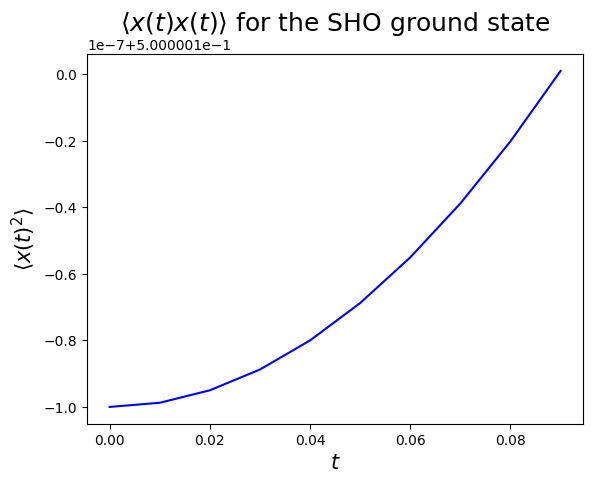

In [21]:
plt.plot(t_values, x_values, color = 'blue')
plt.xlabel('$t$', size = 15)
plt.ylabel(r'$\langle x(t)^2 \rangle$', size = 15)
plt.title(r'$\langle x(t) x(t) \rangle$ for the SHO ground state', size = 18)
plt.show()

## Wavepacket with finite momentum

In [22]:
def psi_wp(x_arr: np.ndarray,x0: float, p0: float, sigma_x: float) -> np.ndarray:
    packet = np.exp( - (x_arr - x0) ** 2 / 4 / sigma_x ** 2)
    mom_term = np.exp( 1j * p0 * (x_arr - x0))
    return mom_term * packet / (2 * np.pi) ** (1/4) / np.sqrt(sigma_x)

In [23]:
x_grid = np.linspace( - x_max, x_max, 2 ** num_qubits)

In [24]:
coeffs_list = psi_wp(x_grid, -2, 1, 1) * np.sqrt(delta_x)
delta_t = 0.1
trotter_steps = 100

In [25]:
x_values = []
t_values = [step * delta_t for step in range(trotter_steps)]

In [26]:
# exact function to give the wavepacket
def x_exp_exact(x0: float, p0: float, t_arr: np.ndarray) -> np.ndarray:
    x_term = np.cos(t_arr)
    p_term = np.sin(t_arr)
    return x0 * x_term + p0 * p_term

In [27]:
x_values_bch = []

In [28]:
for steps in range(trotter_steps):
    sho_gs = QuantumCircuit(num_qubits)
    sho_gs.initialize(coeffs_list, range(num_qubits)) # prepare the quantum circuita
    full_evolution(sho_gs, x_max, num_qubits, delta_t, steps, True)
    estimator = StatevectorEstimator()
    job = estimator.run([(sho_gs, x_op, [])])
    results = job.result()[0]
    x_values.append(results.data.evs)

KeyboardInterrupt: 

In [ ]:
x_exact = x_exp_exact(-2, 1, t_values)

In [ ]:
plt.rcParams['text.usetex'] = True

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
# Main plot
plt.plot(t_values, x_values, color='blue', label='Strang-split')
plt.plot(t_values, x_exact, color='red', label='Exact')
plt.plot(t_values, x_values_bch, color='green', label='BCH')
plt.xlabel('$t$', size=15)
plt.ylabel(r'$\langle x(t) \rangle$', size=15)
plt.legend()
# plt.title(r'$\langle x(t) \rangle$ for wavepacket', size=18)

# Add inset axes with custom coordinates (lower than 'upper right')
ax_inset = inset_axes(plt.gca(), width="20%", height="20%", loc = 'lower right',
                      bbox_to_anchor=(-0.2, 0.3, 1, 1),  # x0, y0, width, height
                      bbox_transform=plt.gcf().transFigure)

ax_inset.plot(t_values, x_values, color='blue')
ax_inset.plot(t_values, x_exact, color='red')
ax_inset.plot(t_values, x_values_bch, color='green')

# Set inset limits for zoomed-in; region
ax_inset.set_xlim(1, 2)
ax_inset.set_ylim(-0.5, 1.75)

# Remove ticks for clarity
ax_inset.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('./plots/SHOwavepacket.png', dpi=300)

plt.show()

# Anharmonic oscillator

The anharmonic oscillator has the Hamiltonian
\begin{equation}
H = \frac{p^2}{2} + \frac{x^2}{2} + \lambda x^4
\end{equation}
For this we need
\begin{equation}
x^4 = \left(\frac{x_{\text{max}}}{2^{N} - 1}\right)^4 \sum_{i, j, k, l} 2^{i + j + k + l} Z_i Z_j Z_k Z_l
\end{equation}
We can reduce the number of gates applied by noting that the above reduces to identity when all the four sites are equal giving rise to an irrelevant global phase. Moreover, when any two of the site indices are equal, say $i = j$, then we have a two-qubit $Z-Z$ interaction (provided $k \neq l \neq i$).

For the case when all four sites are distinct, we have symmetry under permutations of $(i, j, k, l)$. Therefore, we can write this contribution as
\begin{equation}
\left(\frac{x_{\text{max}}}{2^N - 1}\right)^{4} 4! \sum_{i<j<k<l} 2^{i+j+k+l} Z_iZ_jZ_kZ_l
\end{equation}
Next, when there are two equal indices, we have the following contribution
\begin{equation}
2 \left(\frac{x_{\text{max}}}{2^N - 1}\right)^4 \, {}^4 C_2 \sum_{i = 0}^{N - 1} \sum_{k < l, k \neq i, l \neq i} 2^{2i + k + l} Z_k Z_l
\end{equation}
Finally, when there are three indices equal, we have
\begin{equation}
\left(\frac{x_{\text{max}}}{2^N - 1}\right)\, {}^4 C_3 \sum_{i = 0}^{N - 1}\sum_{j \neq i} 2^{3 i + j} Z_i Z_j
\end{equation}

In [12]:
def rz4(qc: QuantumCircuit, theta: float, i: int, j: int, k: int, l: int):
    qc.cx(i, j)
    qc.cx(j, k)
    qc.cx(k, l)
    qc.rz(theta, l)
    qc.cx(k, l)
    qc.cx(j, k)
    qc.cx(i, j)

In [13]:
def apply_x4(qc: QuantumCircuit, lam: float, delta_t: float, x_max: float):
    qubits = qc.num_qubits
    x_prefactor = - x_max / (2 ** qubits - 1)
    delta_x = 2 * x_max / (2 ** qubits - 1)
    p_prefactor = - np.pi / (2 ** qubits * delta_x)
    '''
    Apply the potential term.
    First we will apply the four-site Z interaction.
    '''
    for i in range(qubits):
        for j in range(i+1, qubits):
            for k in range(j+1, qubits):
                for l in range(k+1, qubits):
                    coeff = 2 ** (i+j+k+l) * 24 * lam * x_prefactor ** 4
                    rz4(qc, 2 * coeff * delta_t, i, j, k, l)
    '''
    Now we will apply the two-site term where two indices are equal.
    '''
    for i in range(qubits):
        for j in range(qubits):
            if j == i:
                continue
            for k in range(j+1, qubits):
                if k == i:
                    continue
                coeff = 2 ** (2 * i + j + k) * 12 * lam * x_prefactor ** 4
                rz2(qc, 2 * coeff * delta_t, j, k)
    '''
    Finally apply the two site term where three indices are equal.
    '''
    for i in range(qubits):
        for j in range(qubits):
            if j == i:
                continue
            coeff = 2 ** (3 * i + j) * 4 * lam * x_prefactor ** 4
            rz2(qc, 2 * coeff * delta_t, i, j)
                

In [14]:
def anharmonic_trotter_step(qc: QuantumCircuit, lam: float, delta_t: float, x_max: float):
    qubits = qc.num_qubits
    x_prefactor = - x_max / (2 ** qubits - 1)
    delta_x = 2 * x_max / (2 ** qubits - 1)
    p_prefactor = - np.pi / (2 ** qubits * delta_x)
    # first apply the x^2 evolution
    for i in range(qubits):
        for j in range(i + 1, qubits):
            coeff = 2 ** (i + j) * x_prefactor ** 2
            rz2(qc, 2 * coeff * delta_t, i, j)

    # apply the potential term
    apply_x4(qc, lam, delta_t, x_max)
    # then do a fourier transform
    # do_qft(qc)
    alpha = (1 / 2 ** qubits - 1) * np.pi
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    qc.append(QFTGate(qubits), range(qubits))
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    # then again apply the p^2 evolution now
    for i in range(qubits):
        for j in range(i + 1, qubits):
            coeff = 2 ** (i + j) * p_prefactor ** 2
            rz2(qc, 2 * coeff * delta_t, i, j)
    # apply the inverse fourier transform
    # do_iqft
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)
    qc.append(QFTGate(qubits).inverse(), range(qubits))
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)

In [15]:
qc = QuantumCircuit(4)

In [16]:
anharmonic_trotter_step(qc, 0.1, 0.1, 10)

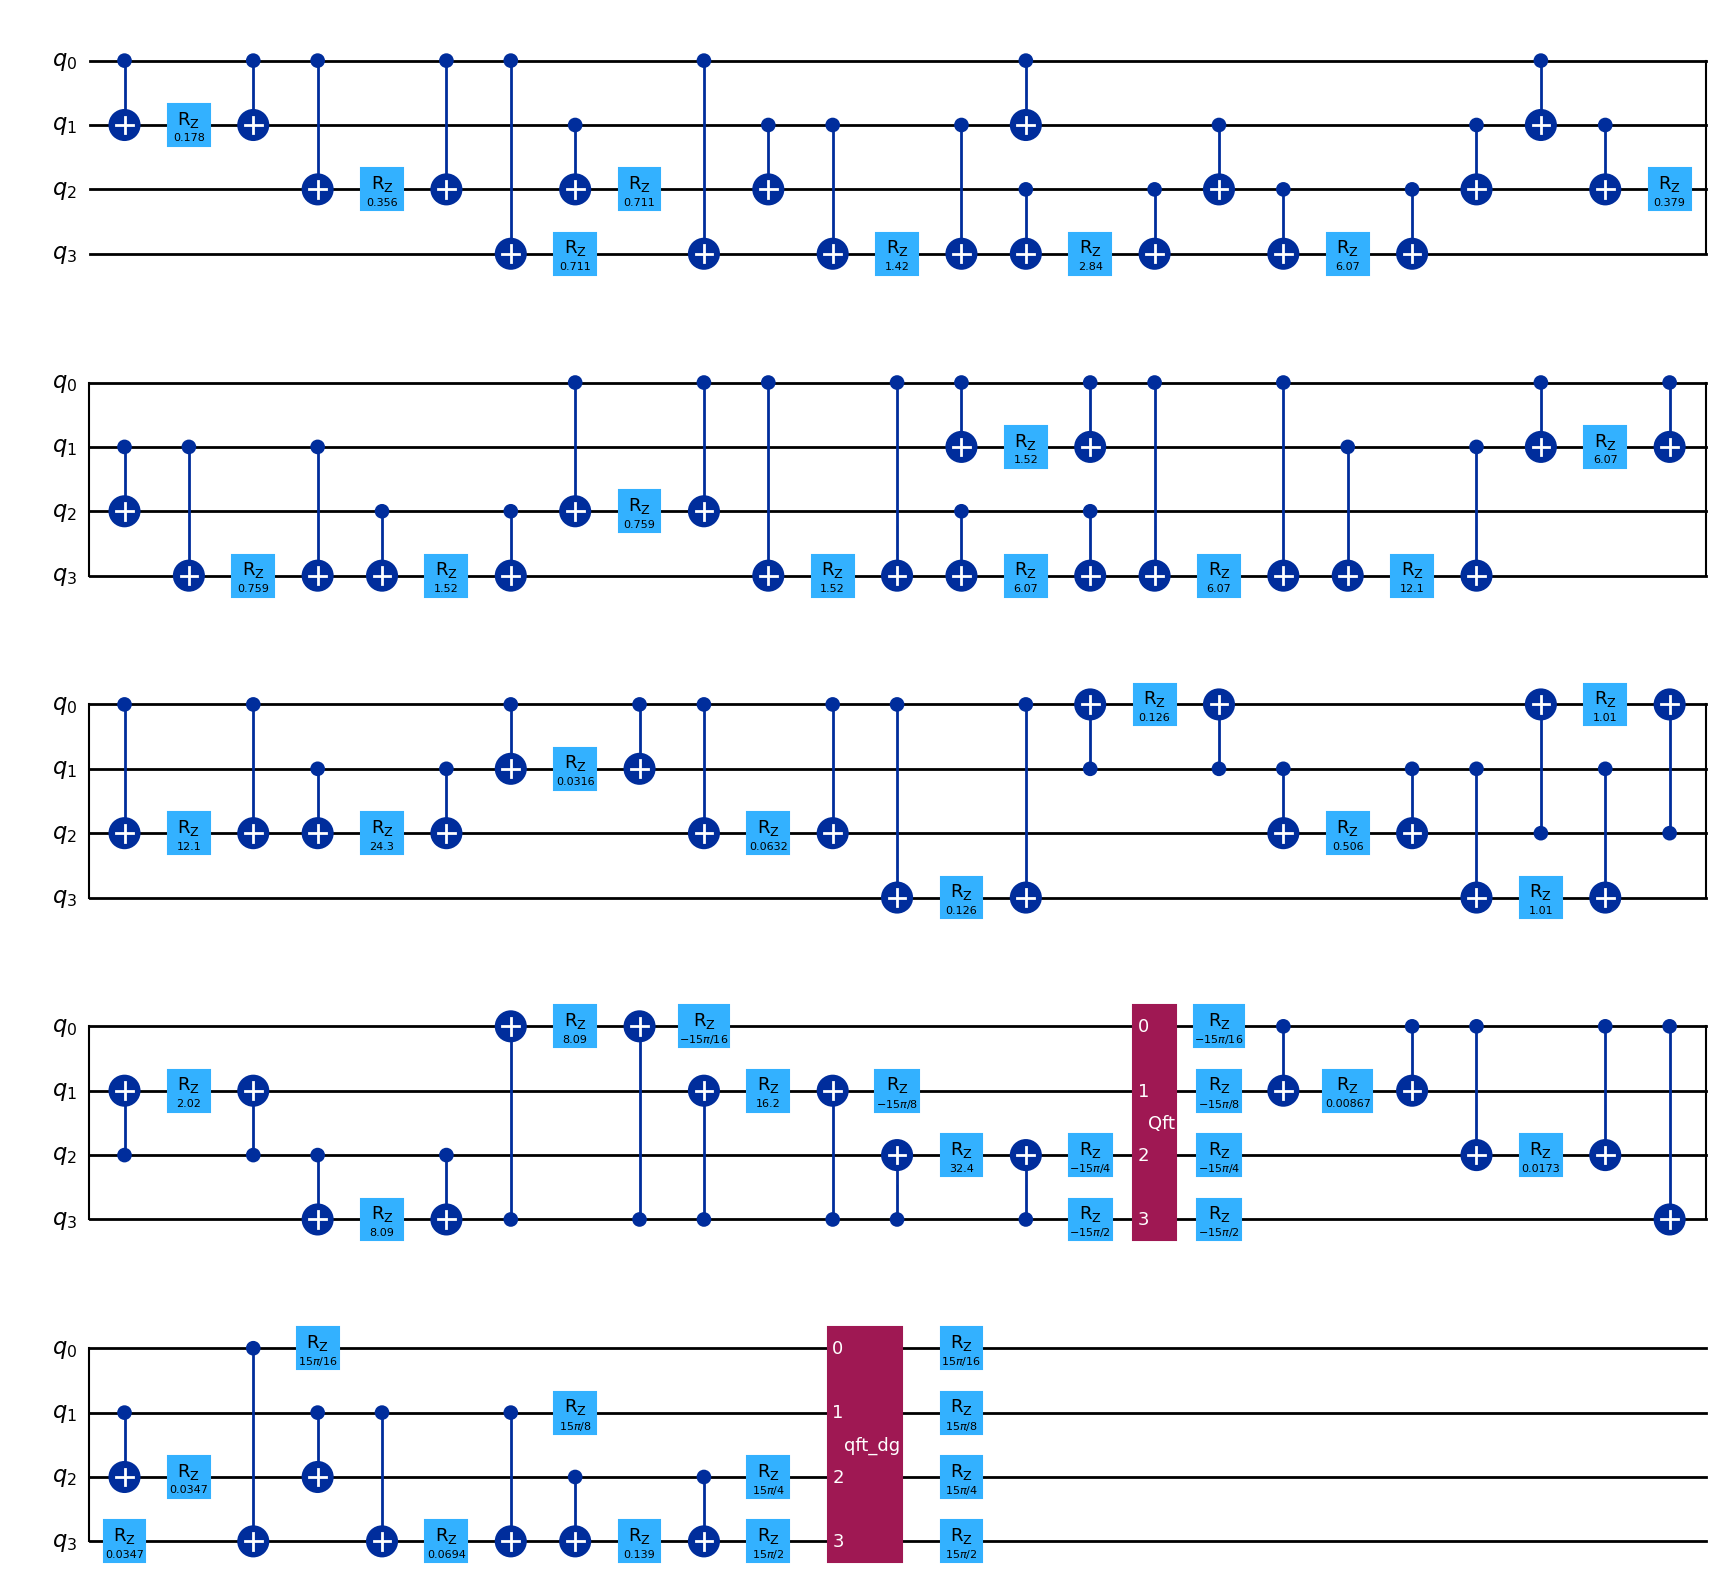

In [17]:
qc.draw('mpl')

In [32]:
def anharmonic_strang(qc: QuantumCircuit, lam: float, delta_t: float, x_max: float):
    qubits = qc.num_qubits
    x_prefactor = - x_max / (2 ** qubits - 1)
    delta_x = 2 * x_max / (2 ** qubits - 1)
    p_prefactor = - np.pi / (2 ** qubits * delta_x)
    # first apply the x^2 evolution
    for i in range(qubits):
        for j in range(i + 1, qubits):
            coeff = 2 ** (i + j) * x_prefactor ** 2
            rz2(qc, 2 * coeff * delta_t / 2, i, j)

    # apply the potential term
    apply_x4(qc, lam, delta_t / 2, x_max)
    # then do a fourier transform
    # do_qft(qc)
    alpha = (1 / 2 ** qubits - 1) * np.pi
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    qc.append(QFTGate(qubits), range(qubits))
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, i)
    # then again apply the p^2 evolution now
    for i in range(qubits):
        for j in range(i + 1, qubits):
            coeff = 2 ** (i + j) * p_prefactor ** 2
            rz2(qc, 2 * coeff * delta_t, i, j)
    # apply the inverse fourier transform
    # do_iqft
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)
    qc.append(QFTGate(qubits).inverse(), range(qubits))
    for i in range(qubits):
        qc.rz( - alpha * 2 ** i, i)
    # again apply the x^2 evolution
    for i in range(qubits):
        for j in range(i + 1, qubits):
            coeff = 2 ** (i + j) * x_prefactor ** 2
            rz2(qc, 2 * coeff * delta_t / 2, i, j)
    apply_x4(qc, lam, delta_t / 2, x_max)

In [33]:
def anharmonic_full_evolution(qc: QuantumCircuit, x_max: float, num_qubits: int,
                   lam: float, delta_t: float, trotter_steps: int, strang: bool = True):
    # qc = QuantumCircuit(num_qubits)
    if strang:
        for _ in range(trotter_steps):
            anharmonic_strang(qc, lam, delta_t, x_max)
    else:
        for _ in range(trotter_steps):
            anharmonic_trotter_step(qc, lam, delta_t, x_max)
    # return qc

In [34]:
lam = 0.1

In [35]:
delta_t = 0.1
trotter_steps = 40

In [36]:
x_values = []
t_values = [t * delta_t for t in range(trotter_steps)]

In [37]:
x_values_bch = []

In [38]:
for steps in range(trotter_steps):
    sho_gs = QuantumCircuit(num_qubits)
    sho_gs.initialize(coeffs_list, range(num_qubits)) # prepare the quantum circuita
    anharmonic_full_evolution(sho_gs, x_max, num_qubits, lam, delta_t, steps, False)
    estimator = StatevectorEstimator()
    job = estimator.run([(sho_gs, x_op, [])])
    results = job.result()[0]
    x_values_bch.append(results.data.evs)

KeyboardInterrupt: 

Let us try a classical simulation to compare

In [ ]:
from scipy.linalg import expm

In [29]:
# Initial state: normalized Gaussian
psi0 = psi_wp(x_list, -2, 1, 1) * np.sqrt(delta_x)
# psi0 /= np.linalg.norm(psi0)

# Hamiltonian parameters
lam = 0.1
delta_t = 0.1
iter_max = 40

# Kinetic energy operator
T = np.zeros((N, N))
for i in range(N):
    if i > 0:
        T[i, i-1] = -0.5
    T[i, i] = 1.0
    if i < N-1:
        T[i, i+1] = -0.5
T /= dx**2

# Potential energy operator
V = np.diag(0.5 * x_grid**2 + lam * x_grid**4)

# Hamiltonian
H = T + V

# Precompute evolution operator
U = expm(-1j * delta_t * H)

# Evolve and compute <x(t)>
x_expect = np.zeros(iter_max + 1, dtype=float)
x_expect[0] = np.sum(np.conj(psi0) * x_grid * psi0).real

psi = psi0.copy()
for n in range(1, iter_max+1):
    psi = U @ psi
    psi /= np.linalg.norm(psi)
    x_expect[n] = np.sum(np.conj(psi) * x_grid * psi).real

NameError: name 'psi_wp' is not defined

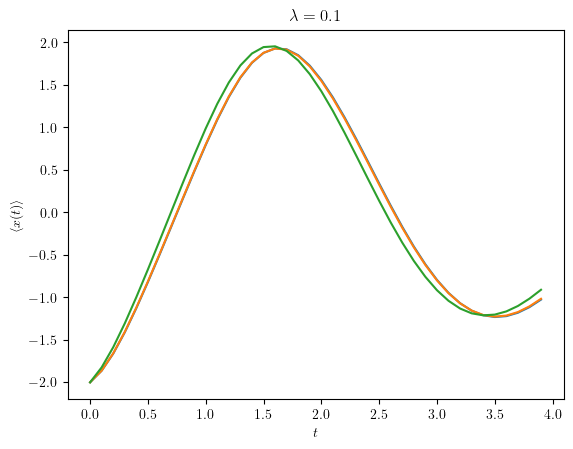

In [292]:
# Plot
t_grid = np.arange(iter_max + 1) * delta_t
plt.plot(t_grid[:-1], x_expect[:-1])
plt.plot(t_values, x_values)
plt.plot(t_values, x_values_bch)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle x(t) \rangle$')
plt.title(r'$\lambda = 0.1$')
plt.show()

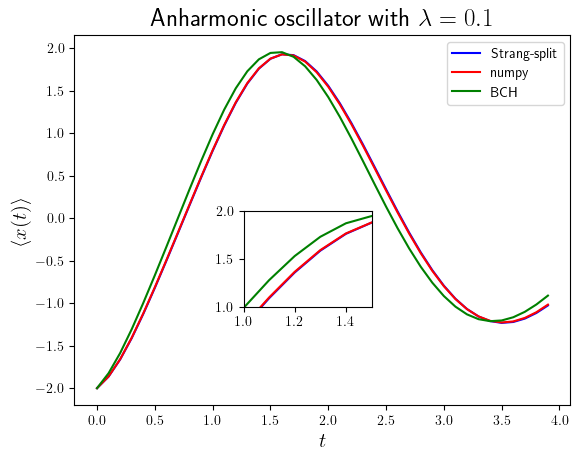

In [299]:
# Main plot
plt.plot(t_grid[:-1], x_expect[:-1], color='blue', label='Strang-split')
plt.plot(t_values, x_values, color='red', label='numpy')
plt.plot(t_values, x_values_bch, color='green', label='BCH')
plt.xlabel('$t$', size=15)
plt.ylabel(r'$\langle x(t) \rangle$', size=15)
plt.title(r'Anharmonic oscillator with $\lambda = 0.1$', size=18)
plt.legend()
# plt.title(r'$\langle x(t) \rangle$ for wavepacket', size=18)

# Add inset axes with custom coordinates (lower than 'upper right')
ax_inset = inset_axes(plt.gca(), width="20%", height="20%", loc = 'lower right',
                      bbox_to_anchor=(-0.4, 0.3, 1, 1),  # x0, y0, width, height
                      bbox_transform=plt.gcf().transFigure)

ax_inset.plot(t_grid[:-1], x_expect[:-1], color='blue')
ax_inset.plot(t_values, x_values, color='red')
ax_inset.plot(t_values, x_values_bch, color='green')

# Set inset limits for zoomed-in; region
ax_inset.set_xlim(1, 1.5)
ax_inset.set_ylim(1, 2)

# Remove ticks for clarity
ax_inset.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('./plots/AHOwavepacket.png', dpi=300)

plt.show()

# Quantum Phase Estimation

Start out with an eigenstate of the Hamiltonian. For starter's let us just look at the ground state. Call it $\ket{\psi_0}$.

In [68]:
x_max = 10
num_qubits = 8
delta_x = 2 * x_max / (2 ** num_qubits - 1)

In [69]:
delta_t = 0.1

In [70]:
import numpy as np

In [71]:
x_list = np.array([-x_max + l * delta_x for l in range(2 ** num_qubits)])
# we can check that this normalizes to one
coeffs_list = np.exp(-x_list ** 2 / 2) * np.sqrt(delta_x) / np.pi ** (1/4)
sho_gs = QuantumCircuit(num_qubits)
sho_gs.initialize(coeffs_list)

In [72]:
from qiskit.circuit.library import phase_estimation

In [73]:
U = QuantumCircuit(num_qubits)

In [74]:
full_evolution(U, x_max, num_qubits, delta_t, 10)

In [75]:
from qiskit.circuit import QuantumRegister, ClassicalRegister

In [76]:
phase_qubits = 4

In [77]:
phase_estimation_circuit = phase_estimation(phase_qubits, U)

In [78]:
qc1 = QuantumRegister(phase_qubits, 'p')
qc2 = QuantumRegister(num_qubits, 'q')

In [79]:
qc = QuantumCircuit(qc1, qc2)

In [80]:
qc.initialize(coeffs_list, qc2)

In [81]:
qc.append(phase_estimation_circuit, range(len(qc1)+len(qc2)))

In [82]:
creg = ClassicalRegister(phase_qubits, 'c')

In [83]:
qc.add_register(creg)

In [84]:
qc.measure(qc1, creg)

In [85]:
from qiskit.primitives import StatevectorSampler

In [86]:
sampler = StatevectorSampler()

In [87]:
job = sampler.run([(qc, [])], shots = 100)

In [88]:
results = job.result()[0]

In [89]:
results.data.c.get_counts()

{'0100': 57,
 '1100': 25,
 '0110': 1,
 '1000': 5,
 '0000': 4,
 '1111': 1,
 '0010': 3,
 '1010': 2,
 '1110': 2}